In [28]:
from torchvision.datasets import Cityscapes
import torch
from torchvision import models
import numpy as np
from torchvision import transforms
import matplotlib.pyplot as plt
from PIL import Image
import re
import os
import torch.nn as nn

# change the datapath everywhere in the notebook, there are few more places
data_path = "/Users/severin/Documents/GitHub/u-net-segmentation-of-streets-and-cars/train/cityscapes"
example_image_path = '/Users/severin/Documents/GitHub/u-net-segmentation-of-streets-and-cars/train/cityscapes/leftImg8bit/test/berlin/berlin_000000_000019_leftImg8bit.png'
example_model_weights = '/Users/severin/Documents/GitHub/u-net-segmentation-of-streets-and-cars/train/model_resnet_weights_epoch_41.pth'

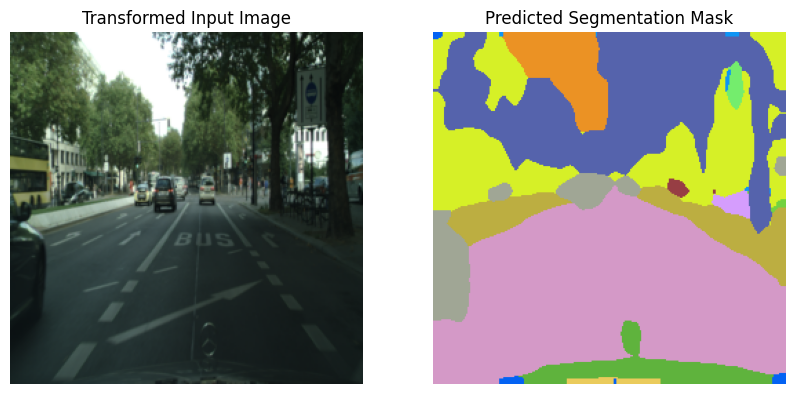

In [27]:
#predict single example

# Define your data transformation (you might need to customize these)
data_transforms = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize images
    transforms.ToTensor(),  # Convert to tensor
])

# Load the state dictionary
state_dict = torch.load(example_model_weights, map_location=torch.device('cpu'))

# Remove keys related to auxiliary classifiers from the state dictionary
state_dict = {k: v for k, v in state_dict.items() if 'aux_classifier' not in k}

# Create your model and load the modified state dictionary
num_classes = len(Cityscapes.classes)
model = models.segmentation.fcn_resnet101(num_classes=num_classes)
model.load_state_dict(state_dict, strict=False)  # Set strict=False to skip missing keys

# Load the input image
input_image = Image.open(example_image_path)

# Apply the necessary transformations
input_tensor = data_transforms(input_image).unsqueeze(0)

# Perform prediction
with torch.no_grad():
    outputs = model(input_tensor)['out']  # Correct 'inputs' to 'input_tensor'
    _, predicted = torch.max(outputs, 1)

# Convert the predicted image tensor to a numpy array
predicted_numpy = predicted.squeeze(0).cpu().numpy()

# Define label colors for 35 classes (replace this with your color mappings)
np.random.seed(42)
label_colors_35_classes = np.random.randint(0, 256, size=(35, 3), dtype=np.uint8)

# Convert the predicted segmentation mask to a colored mask
colored_mask = label_colors_35_classes[predicted_numpy]

# Convert the input tensor back to a numpy array for plotting
input_image_transformed = np.transpose(input_tensor.squeeze(0).cpu().numpy(), (1, 2, 0))

# Plot the transformed input image and the colored mask
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(input_image_transformed)
axs[0].axis('off')
axs[0].set_title('Transformed Input Image')
axs[1].imshow(colored_mask)
axs[1].axis('off')
axs[1].set_title('Predicted Segmentation Mask')

plt.show()

In [ ]:
#predict for multipe epoches and loss

# Define your data transformation (you might need to customize these)
data_transforms = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize images
    transforms.ToTensor(),  # Convert to tensor
])

# Define your target transformation
target_transforms = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize target
    transforms.Lambda(lambda img: torch.Tensor(np.array(img))), 
])

# Create Cityscapes validation dataset instance
val_dataset = Cityscapes(root=data_path, split='val', mode='fine', 
                         target_type='semantic', transform=data_transforms, 
                         target_transform=target_transforms)

# Define the loss function
criterion = nn.CrossEntropyLoss()


# Loop through each epoch
for epoch in range(1, 37):
    # Load the state dictionary for the current epoch
    state_dict = torch.load(f'/Users/severin/Documents/GitHub/u-net-segmentation-of-streets-and-cars/train/model_resnet_weights_epoch_{epoch}.pth',map_location=torch.device('cpu'))

    # Remove keys related to auxiliary classifiers from the state dictionary
    state_dict = {k: v for k, v in state_dict.items() if 'aux_classifier' not in k}

    # Create your model and load the modified state dictionary
    num_classes = len(Cityscapes.classes)  # Replace with the appropriate number of classes
    model = models.segmentation.fcn_resnet101(num_classes=num_classes)
    model.load_state_dict(state_dict, strict=False)  # Set strict=False to skip missing keys

    # Set the model in evaluation mode
    model.eval()

    total_loss = 0.0
    total_loss = 0.0
    num_samples = 20  # Number of random samples per epoch

    # Sample 20 random indices from the validation dataset
    random_indices = np.random.choice(len(val_dataset), num_samples, replace=False)
    
    for i in random_indices:
        input_image, target = val_dataset[i]

        # Add batch dimension to the input image
        input_image = input_image.unsqueeze(0)

        # Perform prediction
        with torch.no_grad():
            outputs = model(input_image)['out']
            loss = criterion(outputs, target.unsqueeze(0).long())  # Calculate the loss

        total_loss += loss.item()

    # Calculate the average loss for the epoch
    avg_loss = total_loss / num_samples
    print(f"Validation Loss - Epoch {epoch}: {avg_loss:.4f}")

    # Create a figure for visualization
    fig, axs = plt.subplots(1, 1, figsize=(8, 8))

    # Load the input image for prediction (modify the path as needed)
    input_image = Image.open(f'/Users/severin/Documents/GitHub/u-net-segmentation-of-streets-and-cars/web/images/image_1_real.jpg')

    # Apply transformations
    input_tensor = data_transforms(input_image).unsqueeze(0)

    # Perform prediction
    with torch.no_grad():
        outputs = model(input_tensor)['out']
        _, predicted = torch.max(outputs, 1)

    # Convert tensors to numpy arrays for visualization
    predicted_numpy = predicted.squeeze(0).cpu().numpy()
    np.random.seed(42)
    label_colors_35_classes = np.random.randint(0, 256, size=(35, 3), dtype=np.uint8)
    colored_mask = label_colors_35_classes[predicted_numpy]
    input_image_transformed = np.transpose(input_tensor.squeeze(0).cpu().numpy(), (1, 2, 0))

    # Create a figure for visualization
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(input_image_transformed)
    axs[0].axis('off')
    axs[0].set_title(f'Transformed Input Image - Epoch {epoch}')
    axs[1].imshow(colored_mask)
    axs[1].axis('off')
    axs[1].set_title(f'Predicted Segmentation Mask - Epoch {epoch}')

    loss_text = f'Validation Loss: {avg_loss:.4f}'
    fig.text(0.5, 0.05, loss_text, color='red', fontsize=12, fontweight='bold', ha='center')  # Adjust the position as needed


    # Save the figure with a unique filename for each epoch
    plt.savefig(f'resnet_prediction_epoch_{epoch}.png')
plt.close()  # Close the figure to avoid displaying all plots at once

In [17]:
#create gif from multiple epoches images

folder_path = ''

# Create a list to store each image frame
frames = []
for epoch in range(1, 36):
    # Construct the filename for each epoch
    image_file = f'resnet_prediction_epoch_{epoch}.png'
    image_path = os.path.join(folder_path, image_file)

    # Open each image and append it to the frames list
    frames.append(Image.open(image_path))

# Save the frames as an animated GIF
gif_path = 'resnet_segmentation.gif'  # Path to save the GIF file
frames[0].save(gif_path, format='GIF', append_images=frames[1:], save_all=True, duration=500, loop=0)


In [38]:
#predict video

import os
import cv2

def extract_frames(input_file, output_folder):
    # Create output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Open the video file
    cap = cv2.VideoCapture(input_file)
    if not cap.isOpened():
        print("Error opening video file")
        return

    fps = cap.get(cv2.CAP_PROP_FPS)

    # Get video width and height
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Define the codec and create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    out = cv2.VideoWriter('output.avi', fourcc, 4, (width, height // 4))

    # Variables for frame extraction
    frame_number = 0

    while True:
        ret, frame = cap.read()

        if not ret:
            break

        # Keep 3/4 from the top
        frame = frame[:3 * height // 4, :, :]

        # Write the frame to the output video
        out.write(frame)

        # Extract frames at 4 frames per second
        if frame_number % int(fps / 4) == 0:
            cv2.imwrite(f"{output_folder}/frame_{frame_number}.jpg", frame)

        frame_number += 1

    # Release video capture and writer objects
    cap.release()
    out.release()

# Input MP4 file and output folder
input_video = 'video_example.mp4'
output_frames_folder = 'video'

# Call function to extract frames
extract_frames(input_video, output_frames_folder)

# Define your data transformation (you might need to customize these)
data_transforms = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize images
    transforms.ToTensor(),  # Convert to tensor
])

# Load the state dictionary
state_dict = torch.load(example_model_weights, map_location=torch.device('cpu'))

# Remove keys related to auxiliary classifiers from the state dictionary
state_dict = {k: v for k, v in state_dict.items() if 'aux_classifier' not in k}

# Create your model and load the modified state dictionary
num_classes = len(Cityscapes.classes)
model = models.segmentation.fcn_resnet101(num_classes=num_classes)
model.load_state_dict(state_dict, strict=False)  # Set strict=False to skip missing keys


folder_path = 'video'  # Replace this with the path to your folder

# Get a list of all files in the folder that match the pattern 'frame_*.jpg'
files = [f for f in os.listdir(folder_path) if re.match(r'frame_\d+\.jpg', f)]
files.sort(key=lambda x: int(re.search(r'\d+', x).group()))

# Loop through each file
for frame, file in enumerate(files):
    file_path = os.path.join(folder_path, file)

    # Load the input image
    input_image = Image.open(file_path)

    # Apply the necessary transformations
    input_tensor = data_transforms(input_image).unsqueeze(0)

    # Perform prediction
    with torch.no_grad():
        outputs = model(input_tensor)['out']  # Correct 'inputs' to 'input_tensor'
        _, predicted = torch.max(outputs, 1)

    # Convert the predicted image tensor to a numpy array
    predicted_numpy = predicted.squeeze(0).cpu().numpy()

    # Define label colors for 35 classes (replace this with your color mappings)
    np.random.seed(42)
    label_colors_35_classes = np.random.randint(0, 256, size=(35, 3), dtype=np.uint8)

    # Convert the predicted segmentation mask to a colored mask
    colored_mask = label_colors_35_classes[predicted_numpy]

    # Convert the input tensor back to a numpy array for plotting
    input_image_transformed = np.transpose(input_tensor.squeeze(0).cpu().numpy(), (1, 2, 0))

    # Plot the input image and predicted segmentation mask on top of each other
    fig, ax = plt.subplots(figsize=(15, 10))

    # Plot the input image
    ax.imshow(input_image_transformed)
    ax.axis('off')

    # Plot the predicted segmentation mask with reduced opacity on top of the input image
    ax.imshow(colored_mask, alpha=0.6)
    ax.axis('off')
    
    # Set the title
    ax.set_title(f'Input Image with Predicted Segmentation Mask (Frame {frame})')

    # Export the figure for each epoch and file
    plt.savefig(f'{folder_path}/resnet_prediction_video_{frame}.png')
    plt.close()

In [46]:
#create gif from video

# Folder where the prediction images are stored
folder_path = 'video'

# Create a list to store each image frame
frames = []
for frame in range(0, 730):
    # Construct the filename for each epoch
    image_file = f'segnet_prediction_video_{frame}.png'
    image_path = os.path.join(folder_path, image_file)

    # Open each image and append it to the frames list
    frames.append(Image.open(image_path))

# Save the frames as an animated GIF
gif_path = 'resnet_video.gif'  # Path to save the GIF file
frames[0].save(gif_path, format='GIF', append_images=frames[1:], save_all=True, duration=400, loop=0)